# Stock Market Prediction using GRU

This notebook performs stock market prediction using a **Gated Recurrent Unit (GRU)** model.
It includes the following steps:
- Data Collection (Using `yfinance`)
- Data Preprocessing
- Exploratory Data Analysis (EDA)
- Feature Engineering
- Training a GRU Model
- Predicting Stock Prices for the Next 10 Days
- Model Evaluation

**Dataset:** Latest stock data, starting from 10 days before today.


In [5]:
!pip install yfinance


In [7]:
# Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# Set plot style
# plt.style.use("seaborn-darkgrid")


In [9]:
# Fetch stock data (10 days before today)
stock_symbol = "AAPL"  # Change to any stock ticker
data = yf.download(stock_symbol, period="5y", interval="1d")

# Display first few rows
data.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-02-24,72.362038,73.818112,70.190065,72.138777,222195200
2020-02-25,69.910965,73.417680,69.437745,73.034250,230673600
2020-02-26,71.020012,72.289226,69.527537,69.534818,198054800
2020-02-27,66.377556,69.406192,66.241656,68.217067,320605600
2020-02-28,66.338737,67.564271,62.215623,62.431611,426510000


In [11]:
# Extract only the closing prices
closing_prices = data[['Close']]

# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(closing_prices)

# Add Moving Averages (Feature Engineering)
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_200'] = data['Close'].rolling(window=200).mean()

# Drop NA values
data.dropna(inplace=True)

# Display data with new features
data.head()


Price,Close,High,Low,Open,Volume,SMA_50,SMA_200
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,
Date,,,,,,,
2020-12-04,119.411491,120.007328,118.698438,119.753363,78260400,114.083361,92.788199
2020-12-07,120.876656,121.677616,119.411484,119.470088,86712000,114.311212,93.030772
2020-12-08,121.492020,122.078094,120.231971,121.482257,82225500,114.499106,93.288677
2020-12-09,118.952393,123.025568,118.190505,121.638540,115089200,114.653173,93.528339
2020-12-10,120.378502,120.993879,117.360252,117.702124,81312200,114.802220,93.798344


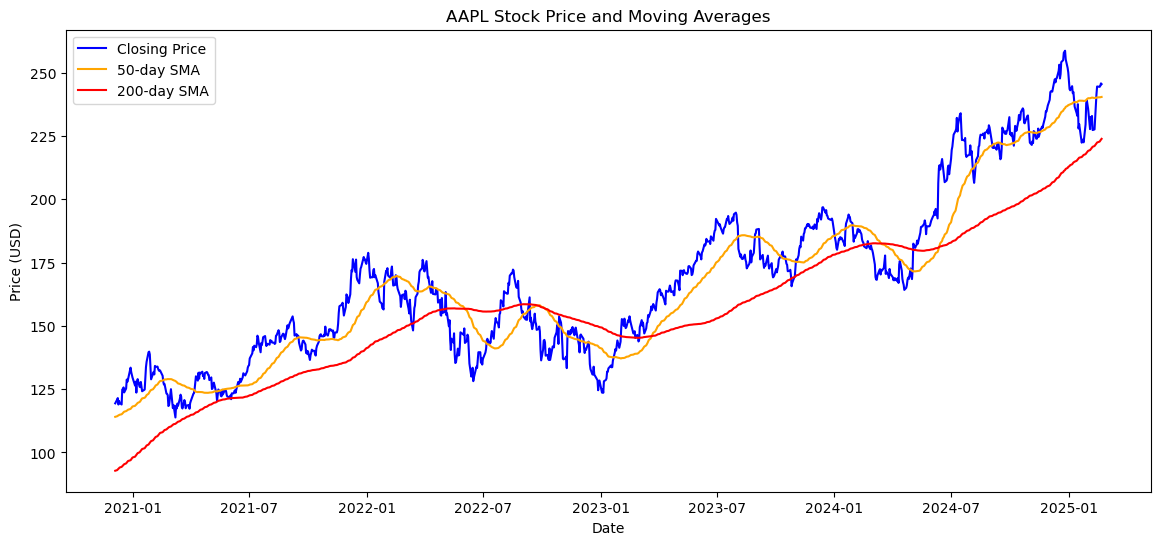

In [13]:
# Visualizing Stock Price and Moving Averages
plt.figure(figsize=(14,6))
plt.plot(data['Close'], label="Closing Price", color='blue')
plt.plot(data['SMA_50'], label="50-day SMA", color='orange')
plt.plot(data['SMA_200'], label="200-day SMA", color='red')
plt.title(f"{stock_symbol} Stock Price and Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


In [15]:
# Function to create sequences for training
def create_sequences(data, time_steps=100):
    X, y = [], []
    for i in range(len(data) - time_steps - 10):  # Reserve last 10 days for future prediction
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])  # Next day as target
    return np.array(X), np.array(y)

# Create sequences
time_steps = 100
X, y = create_sequences(scaled_data, time_steps)

# Reshape data for GRU model
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split into training and test sets (80-20 split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [17]:
# # Build the GRU model
# model = Sequential([
#     GRU(50, return_sequences=True, input_shape=(time_steps, 1)),
#     Dropout(0.2),
#     GRU(50, return_sequences=False),
#     Dropout(0.2),
#     Dense(25),
#     Dense(1)  # Output layer
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Train the model
# history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout

def create_lstm_model(input_shape, dropout_rate):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        LSTM(50, return_sequences=False),
        Dropout(dropout_rate),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def create_gru_model(input_shape, dropout_rate):
    model = Sequential([
        GRU(50, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        GRU(50, return_sequences=False),
        Dropout(dropout_rate),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [19]:
# Get LSTM model and get summary of the model.
lstm_model = create_lstm_model(input_shape=(time_steps, 1), dropout_rate=0.2)
lstm_model.summary()
# Get GRU model and get summary of it.
gru_model = create_gru_model(input_shape=(time_steps, 1), dropout_rate=0.2)
gru_model.summary()

C:\Users\JENIL\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 100, 50)        │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,551 (95.90 KB)

 Trainable params: 24,551 (95.90 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train LSTM and GRU model one by one
# Separate it with big horizontal line
print("=====================================================================")
print("Training LSTM model...")
lstm_model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))
print("=====================================================================")
print("Training GRU model...")
gru_model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))
print("=====================================================================")

Training LSTM model...
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.0756 - val_loss: 0.0037
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0058 - val_loss: 0.0149
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0033 - val_loss: 0.0059
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
LSTM Model:
Root Mean Squared Error: 0.026401942357115665
R² Score: 0.9543827173064722

GRU Model:
Root Mean Squared Error: 0.025231427944013233
R² Score: 0.9583378849347847


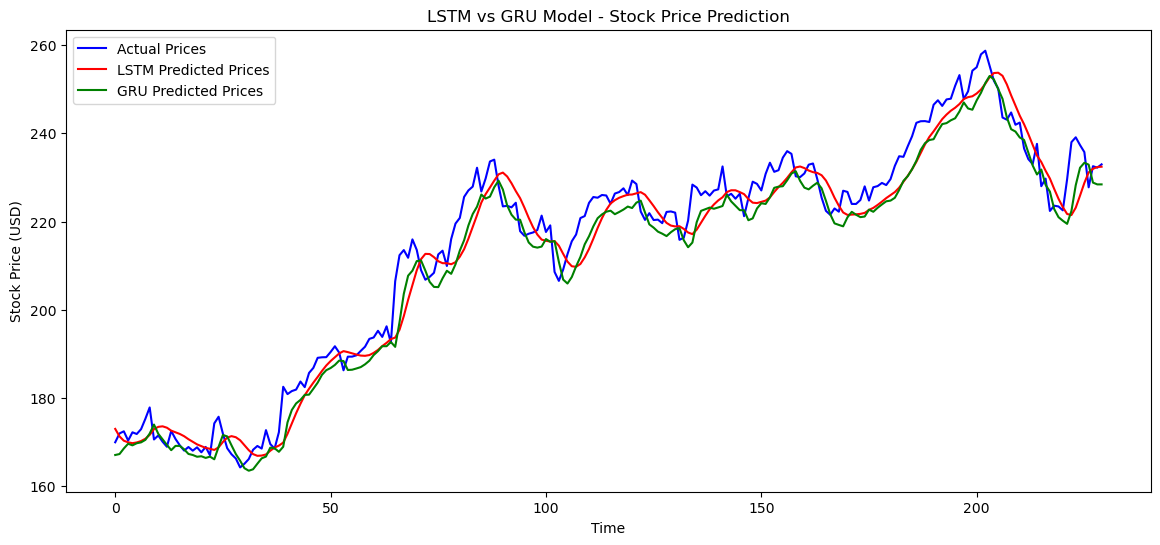

In [23]:
lstm_predictions = lstm_model.predict(X_test)
gru_predictions = gru_model.predict(X_test)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Convert predictiond back to original scale
lstm_predicted_prices = scaler.inverse_transform(lstm_predictions)
gru_predicted_prices = scaler.inverse_transform(gru_predictions)

# Calculate error metrics
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))
lstm_r2 = r2_score(y_test, lstm_predictions)
gru_rmse = np.sqrt(mean_squared_error(y_test, gru_predictions))
gru_r2 = r2_score(y_test, gru_predictions)

# Print results
print("LSTM Model:")
print(f"Root Mean Squared Error: {lstm_rmse}")
print(f"R² Score: {lstm_r2}")
print("\nGRU Model:")
print(f"Root Mean Squared Error: {gru_rmse}")
print(f"R² Score: {gru_r2}")

# Plot Actual vs Predicted prices
plt.figure(figsize=(14,6))
plt.plot(actual_prices, label="Actual Prices", color='blue')
plt.plot(lstm_predicted_prices, label="LSTM Predicted Prices", color='red')
plt.plot(gru_predicted_prices, label="GRU Predicted Prices", color='green')
plt.title("LSTM vs GRU Model - Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Stock Prices for the Next 10 Days:
LSTM Model:
[242.69241 243.5424  243.8792  243.89378 243.69858 243.36044 242.92021
 242.40398 241.82924 241.20863]

GRU Model:
[241.50418 239.7112  237.6851  235.62544 233.55264 231.47939 229.416

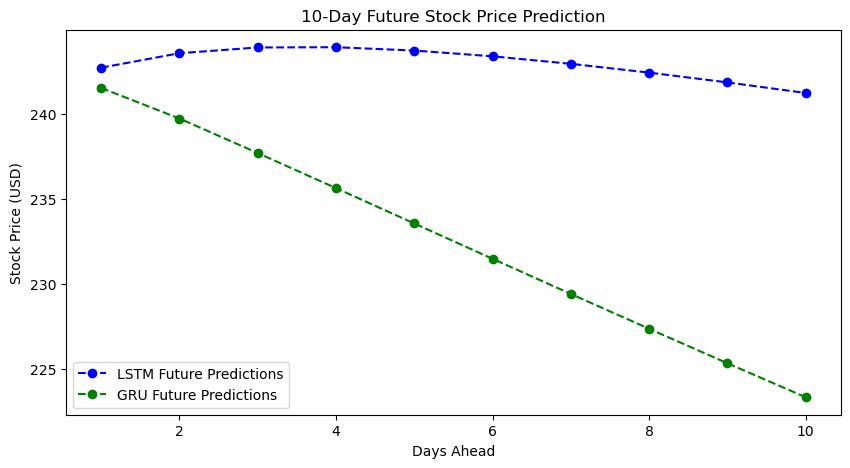

In [25]:
# Prepare the last 100 dats for future prediction
last_100_days_lstm = scaled_data[-100:].reshape(1, 100, 1)
last_100_days_gru = scaled_data[-100:].reshape(1, 100, 1)

# Predict next 10 days
future_prediction_lstm = []
future_prediction_gru = []
for _ in range(10):
    lstm_predicted = lstm_model.predict(last_100_days_lstm)[0][0]
    gru_predicted = gru_model.predict(last_100_days_gru)[0][0]
    future_prediction_lstm.append(lstm_predicted)
    future_prediction_gru.append(gru_predicted)
    last_100_days_lstm = np.append(last_100_days_lstm[:,1:,:], [[[lstm_predicted]]], axis=1)
    last_100_days_gru = np.append(last_100_days_gru[:,1:,:], [[[gru_predicted]]], axis=1)

# Conver future predictions back to original scale
future_prices_lstm = scaler.inverse_transform(np.array(future_prediction_lstm).reshape(-1,1))
future_prices_gru = scaler.inverse_transform(np.array(future_prediction_gru).reshape(-1,1))

# Display results
print("Predicted Stock Prices for the Next 10 Days:")
print("LSTM Model:")
print(future_prices_lstm.flatten())
print("\nGRU Model:")
print(future_prices_gru.flatten())

# Plot the future predictions
plt.figure(figsize=(10,5))
plt.plot(range(1,11), future_prices_lstm, marker='o', linestyle='dashed', color='blue', label="LSTM Future Predictions")
plt.plot(range(1,11), future_prices_gru, marker='o', linestyle='dashed', color='green', label="GRU Future Predictions")
plt.title("10-Day Future Stock Price Prediction")
plt.xlabel("Days Ahead")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()

Comparison of Actual vs. Predicted Prices:
   Actual Price  Predicted Price  Difference  Percentage Difference (%)
0    169.927628       172.963974   -3.036346                  -1.786847
1    171.938126       171.258896    0.679230                   0.395043
2    172.415878       170.283051    2.132828                   1.237025
3    170.325760       169.920639    0.405121                   0.237851
4    172.186951       169.723938    2.463013                   1.430429


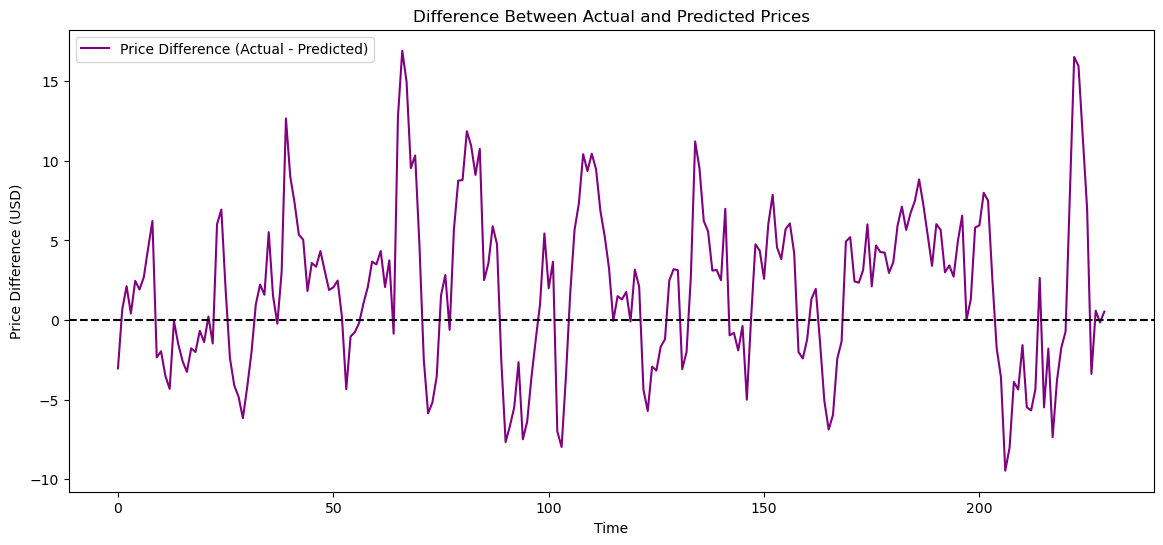

In [27]:
# Compute differences between actual and predicted prices
price_differences = actual_prices - lstm_predicted_prices
percentage_differences = (price_differences / actual_prices) * 100  # Percentage difference

# Convert to DataFrame for better visualization
comparison_df = pd.DataFrame({
    "Actual Price": actual_prices.flatten(),
    "Predicted Price": lstm_predicted_prices.flatten(),
    "Difference": price_differences.flatten(),
    "Percentage Difference (%)": percentage_differences.flatten()
})

# Display first few rows
print("Comparison of Actual vs. Predicted Prices:")
print(comparison_df.head())

# Plot the difference
plt.figure(figsize=(14,6))
plt.plot(price_differences, label="Price Difference (Actual - Predicted)", color='purple')
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Difference Between Actual and Predicted Prices")
plt.xlabel("Time")
plt.ylabel("Price Difference (USD)")
plt.legend()
plt.show()


Comparison of Actual vs. Predicted Prices:
   Actual Price  Predicted Price  Difference  Percentage Difference (%)
0    169.927628       167.044495    2.883133                   1.696683
1    171.938126       167.261154    4.676971                   2.720148
2    172.415878       168.525330    3.890549                   2.256491
3    170.325760       169.596268    0.729492                   0.428292
4    172.186951       169.233826    2.953125                   1.715069


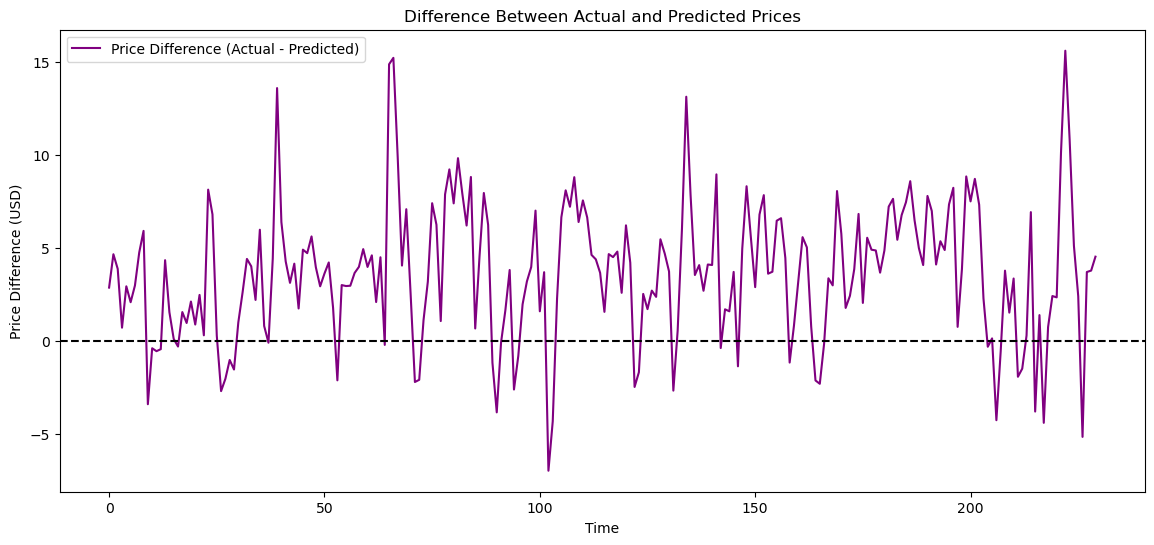

In [29]:
# Lets do the same price difference calculation for GRU
price_differences_gru = actual_prices - gru_predicted_prices
percentage_differences_gru = (price_differences_gru / actual_prices) * 100  # Percentage difference

# Convert them into dataframe for better visualization
comparison_df_gru = pd.DataFrame({
    "Actual Price": actual_prices.flatten(),
    "Predicted Price": gru_predicted_prices.flatten(),
    "Difference": price_differences_gru.flatten(),
    "Percentage Difference (%)": percentage_differences_gru.flatten()
})

# Display first few rows
print("Comparison of Actual vs. Predicted Prices:")
print(comparison_df_gru.head())

# Plot the difference
plt.figure(figsize=(14,6))
plt.plot(price_differences_gru, label="Price Difference (Actual - Predicted)", color='purple')
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Difference Between Actual and Predicted Prices")
plt.xlabel("Time")
plt.ylabel("Price Difference (USD)")
plt.legend()
plt.show()

In [55]:
# Define a Hybrid LSTM-GRU Model
def create_hybrid_model(input_shape, dropout_rate=0.2):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        GRU(50, return_sequences=False),
        Dropout(dropout_rate),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [57]:
# Create the Hybrid Model
hybrid_model = create_hybrid_model(input_shape=(time_steps, 1), dropout_rate=0.2)
hybrid_model.summary()

C:\Users\JENIL\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,001 (105.47 KB)

 Trainable params: 27,001 (105.47 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# Train the Hybrid Model
print("=====================================================================")
print("Training Hybrid LSTM-GRU model...")
hybrid_model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))
print("=====================================================================")


Training Hybrid LSTM-GRU model...
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0683 - val_loss: 0.0105
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0047 - val_loss: 0.0068
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0019 - val_loss: 9.4128e-04
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0016 - val_loss: 9.3679e-04
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 12/50
29/29 ━━━

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step
Hybrid Model:
Root Mean Squared Error: 0.02317041371962325
R² Score: 0.9648661913520051


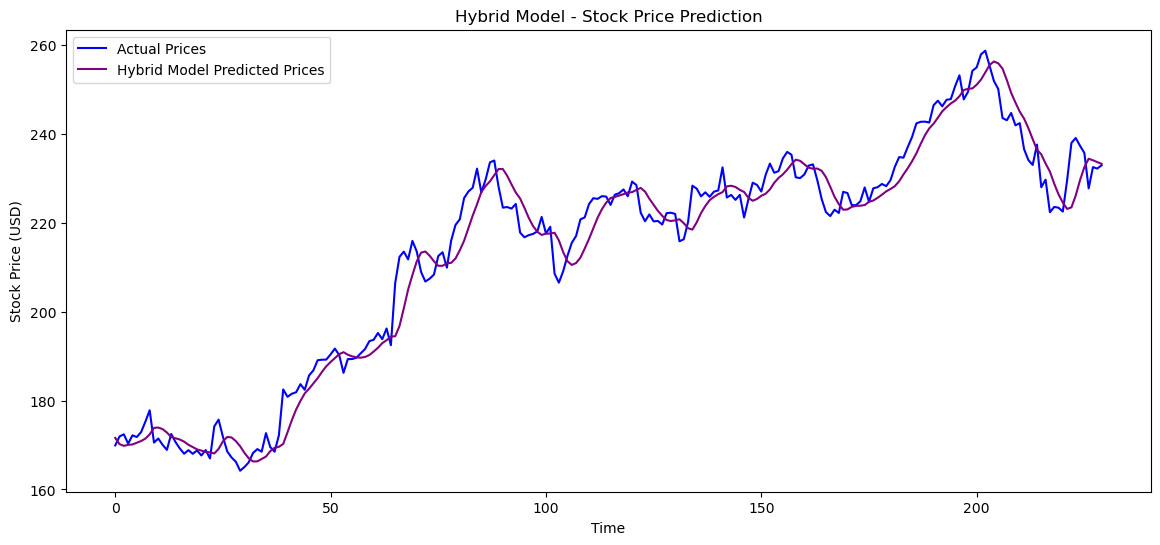

In [61]:
# Predict using the Hybrid Model
hybrid_predictions = hybrid_model.predict(X_test)

# Convert predictions back to original scale
hybrid_predicted_prices = scaler.inverse_transform(hybrid_predictions)

# Calculate error metrics for Hybrid Model
hybrid_rmse = np.sqrt(mean_squared_error(y_test, hybrid_predictions))
hybrid_r2 = r2_score(y_test, hybrid_predictions)

# Print results
print("Hybrid Model:")
print(f"Root Mean Squared Error: {hybrid_rmse}")
print(f"R² Score: {hybrid_r2}")

# Plot Actual vs Predicted prices for Hybrid Model
plt.figure(figsize=(14,6))
plt.plot(actual_prices, label="Actual Prices", color='blue')
plt.plot(hybrid_predicted_prices, label="Hybrid Model Predicted Prices", color='purple')
plt.title("Hybrid Model - Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Hybrid Model - Predicted Stock Prices for the Next 10 Days:
[245.02684 245.72295 246.14685 246.43243 246.63754 246.78877 246.89969
 246.97871 247.03151 247.06255]


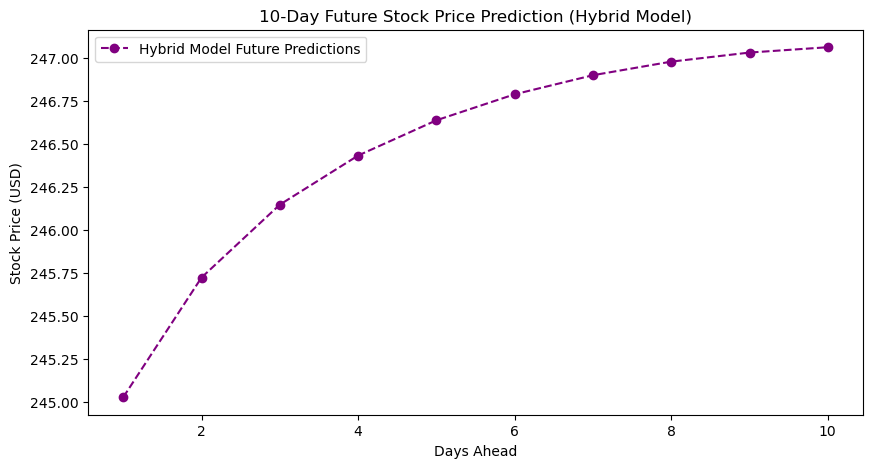

In [63]:
# Future Prediction using Hybrid Model
last_100_days_hybrid = scaled_data[-100:].reshape(1, 100, 1)
future_prediction_hybrid = []
for _ in range(10):
    hybrid_predicted = hybrid_model.predict(last_100_days_hybrid)[0][0]
    future_prediction_hybrid.append(hybrid_predicted)
    last_100_days_hybrid = np.append(last_100_days_hybrid[:,1:,:], [[[hybrid_predicted]]], axis=1)

# Convert future predictions back to original scale
future_prices_hybrid = scaler.inverse_transform(np.array(future_prediction_hybrid).reshape(-1,1))

# Display results
print("\nHybrid Model - Predicted Stock Prices for the Next 10 Days:")
print(future_prices_hybrid.flatten())

# Plot the future predictions
plt.figure(figsize=(10,5))
plt.plot(range(1,11), future_prices_hybrid, marker='o', linestyle='dashed', color='purple', label="Hybrid Model Future Predictions")
plt.title("10-Day Future Stock Price Prediction (Hybrid Model)")
plt.xlabel("Days Ahead")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()

In [65]:
# Compare Errors of All Models
print("\nModel Performance Comparison:")
print(f"LSTM RMSE: {lstm_rmse}, R²: {lstm_r2}")
print(f"GRU RMSE: {gru_rmse}, R²: {gru_r2}")
print(f"Hybrid RMSE: {hybrid_rmse}, R²: {hybrid_r2}")


Model Performance Comparison:
LSTM RMSE: 0.026401942357115665, R²: 0.9543827173064722
GRU RMSE: 0.025231427944013233, R²: 0.9583378849347847
Hybrid RMSE: 0.02317041371962325, R²: 0.9648661913520051


Comparison of Actual vs. Predicted Prices (Hybrid Model):
   Actual Price  Predicted Price  Difference  Percentage Difference (%)
0    169.927628       171.608658   -1.681030                  -0.989262
1    171.938126       170.209595    1.728531                   1.005321
2    172.415878       169.821259    2.594620                   1.504861
3    170.325760       170.047607    0.278152                   0.163306
4    172.186951       170.134933    2.052017                   1.191738


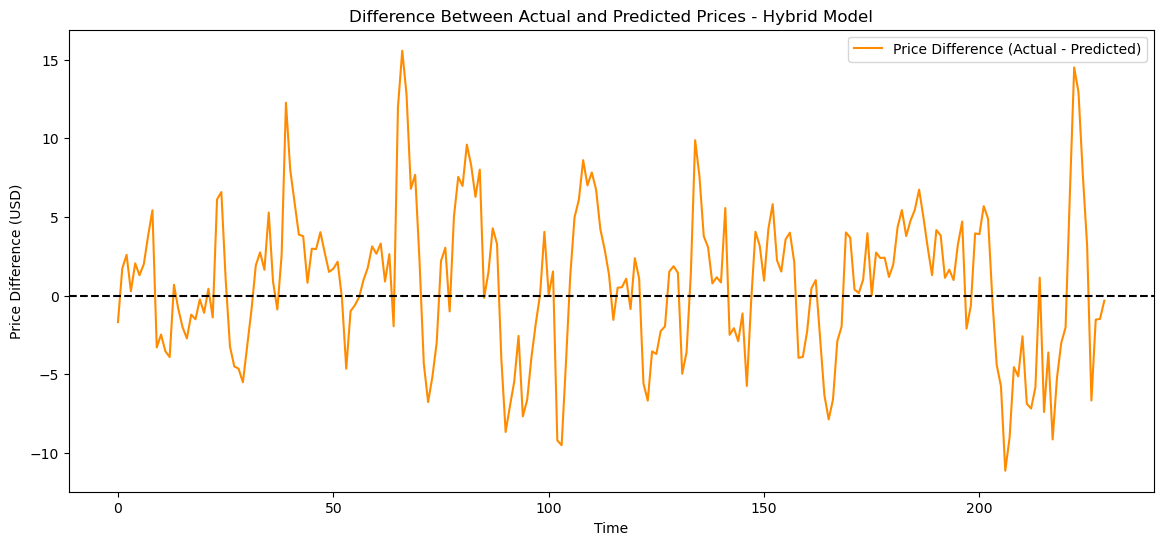

In [67]:
# Calculate price differences for Hybrid Model
price_differences_hybrid = actual_prices - hybrid_predicted_prices
percentage_differences_hybrid = (price_differences_hybrid / actual_prices) * 100  # Percentage difference

# Convert into DataFrame for better visualization
comparison_df_hybrid = pd.DataFrame({
    "Actual Price": actual_prices.flatten(),
    "Predicted Price": hybrid_predicted_prices.flatten(),
    "Difference": price_differences_hybrid.flatten(),
    "Percentage Difference (%)": percentage_differences_hybrid.flatten()
})

# Display first few rows
print("Comparison of Actual vs. Predicted Prices (Hybrid Model):")
print(comparison_df_hybrid.head())

# Plot the difference
plt.figure(figsize=(14,6))
plt.plot(price_differences_hybrid, label="Price Difference (Actual - Predicted)", color='darkorange')
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Difference Between Actual and Predicted Prices - Hybrid Model")
plt.xlabel("Time")
plt.ylabel("Price Difference (USD)")
plt.legend()
plt.show()


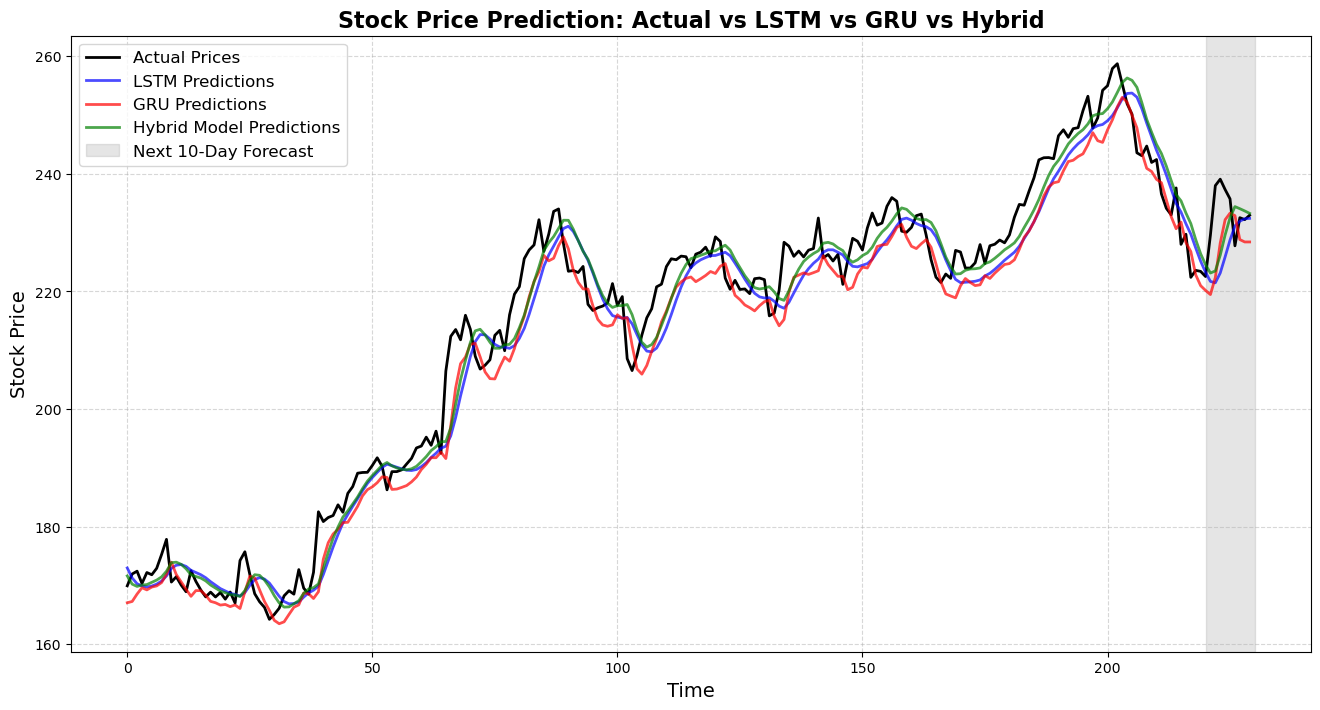

In [69]:
import matplotlib.pyplot as plt

# Increase figure size for better visibility
plt.figure(figsize=(16, 8))

# Plot actual prices with bold solid line
plt.plot(actual_prices, label="Actual Prices", color="black", linewidth=2)

# Plot LSTM predictions with a lighter blue line
plt.plot(lstm_predicted_prices, label="LSTM Predictions", color="blue", linewidth=2, alpha=0.7)

# Plot GRU predictions with a lighter red line
plt.plot(gru_predicted_prices, label="GRU Predictions", color="red", linewidth=2, alpha=0.7)

# Plot Hybrid model predictions with a lighter green line
plt.plot(hybrid_predicted_prices, label="Hybrid Model Predictions", color="green", linewidth=2, alpha=0.7)

# Highlight the next 10 days forecast with a shaded area
plt.axvspan(len(actual_prices) - 10, len(actual_prices), color="gray", alpha=0.2, label="Next 10-Day Forecast")

# Titles and labels
plt.title("Stock Price Prediction: Actual vs LSTM vs GRU vs Hybrid", fontsize=16, fontweight="bold")
plt.xlabel("Time", fontsize=14)
plt.ylabel("Stock Price", fontsize=14)

# Add grid lines for readability
plt.grid(True, linestyle="--", alpha=0.5)

# Show legend outside for better clarity
plt.legend(loc="upper left", fontsize=12, frameon=True)

# Show plot
plt.show()


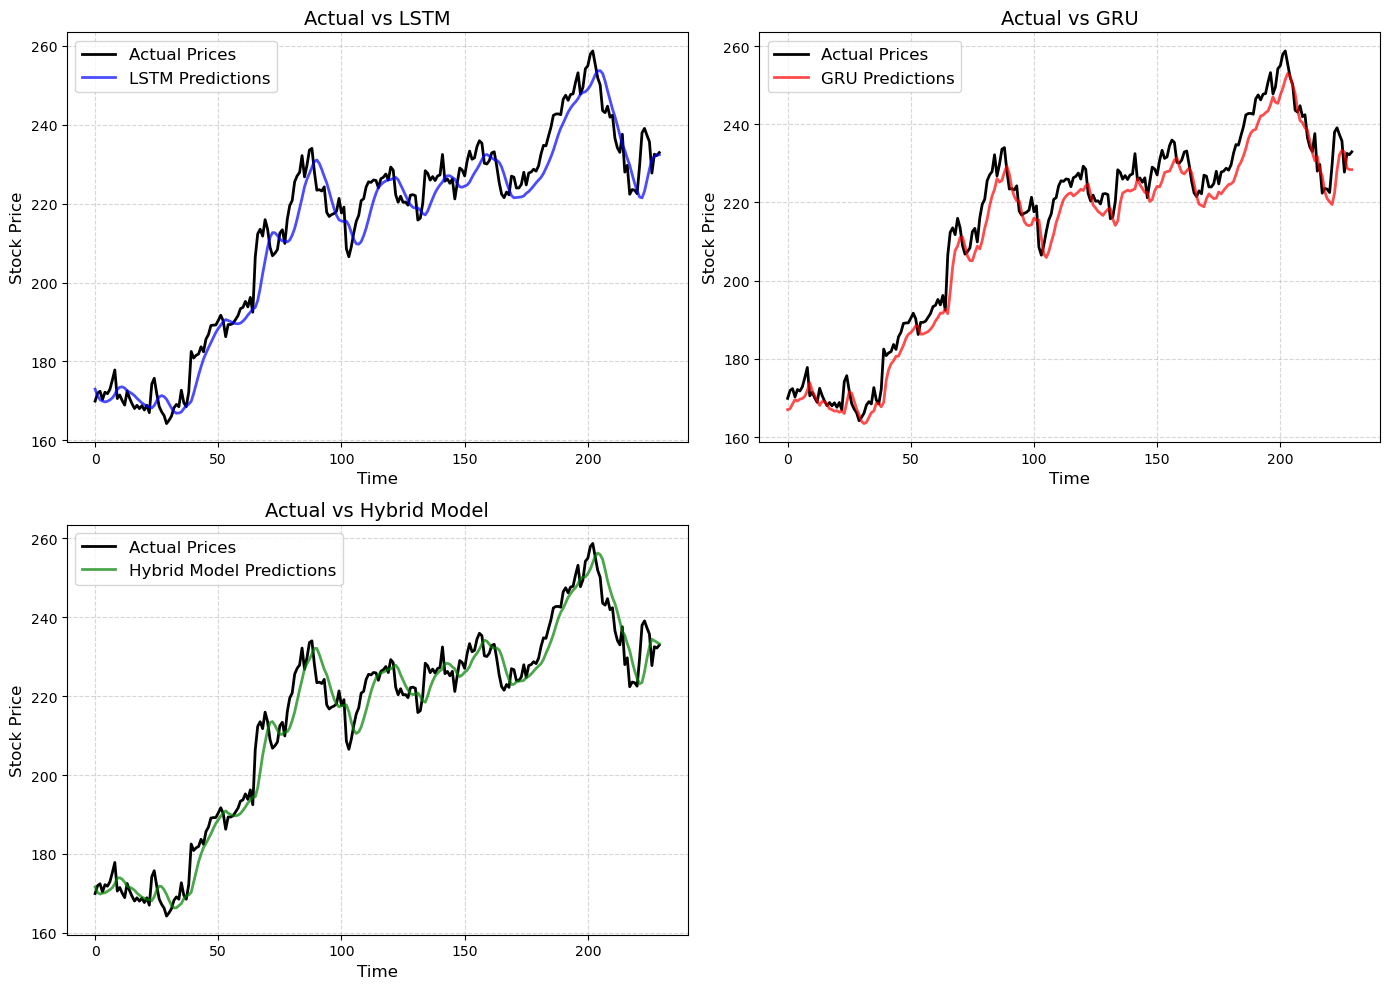

In [71]:
import matplotlib.pyplot as plt

# Define the figure size and grid for subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot Actual vs LSTM
axes[0, 0].plot(actual_prices, label="Actual Prices", color="black", linewidth=2)
axes[0, 0].plot(lstm_predicted_prices, label="LSTM Predictions", color="blue", linewidth=2, alpha=0.7)
axes[0, 0].set_title("Actual vs LSTM", fontsize=14)
axes[0, 0].set_xlabel("Time", fontsize=12)
axes[0, 0].set_ylabel("Stock Price", fontsize=12)
axes[0, 0].legend(loc="best", fontsize=12)
axes[0, 0].grid(True, linestyle="--", alpha=0.5)

# Plot Actual vs GRU
axes[0, 1].plot(actual_prices, label="Actual Prices", color="black", linewidth=2)
axes[0, 1].plot(gru_predicted_prices, label="GRU Predictions", color="red", linewidth=2, alpha=0.7)
axes[0, 1].set_title("Actual vs GRU", fontsize=14)
axes[0, 1].set_xlabel("Time", fontsize=12)
axes[0, 1].set_ylabel("Stock Price", fontsize=12)
axes[0, 1].legend(loc="best", fontsize=12)
axes[0, 1].grid(True, linestyle="--", alpha=0.5)

# Plot Actual vs Hybrid
axes[1, 0].plot(actual_prices, label="Actual Prices", color="black", linewidth=2)
axes[1, 0].plot(hybrid_predicted_prices, label="Hybrid Model Predictions", color="green", linewidth=2, alpha=0.7)
axes[1, 0].set_title("Actual vs Hybrid Model", fontsize=14)
axes[1, 0].set_xlabel("Time", fontsize=12)
axes[1, 0].set_ylabel("Stock Price", fontsize=12)
axes[1, 0].legend(loc="best", fontsize=12)
axes[1, 0].grid(True, linestyle="--", alpha=0.5)

# Remove the empty subplot
axes[1, 1].axis('off')

# Adjust layout for better presentation
plt.tight_layout()

# Show the plot
plt.show()


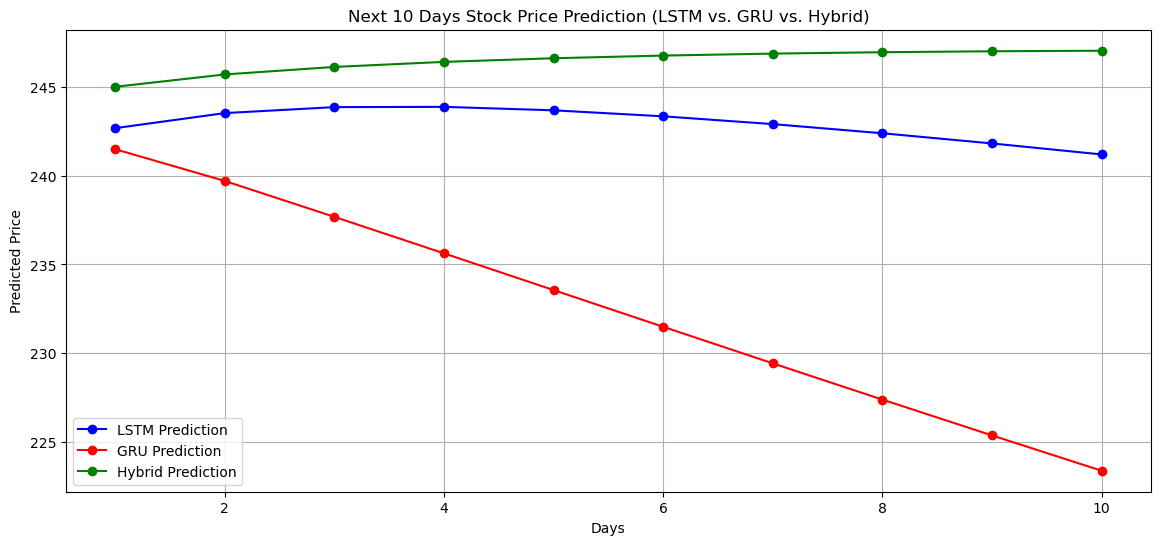

In [73]:
# Assuming you have future predictions stored as:
# lstm_future, gru_future, hybrid_future (each with next 10 days predictions)

days = np.arange(1, 11)  # Days from 1 to 10

plt.figure(figsize=(14,6))
plt.plot(days, future_prices_lstm, label="LSTM Prediction", color='blue', marker='o')
plt.plot(days, future_prices_gru, label="GRU Prediction", color='red', marker='o')
plt.plot(days, future_prices_hybrid, label="Hybrid Prediction", color='green', marker='o')

plt.title("Next 10 Days Stock Price Prediction (LSTM vs. GRU vs. Hybrid)")
plt.xlabel("Days")
plt.ylabel("Predicted Price")
plt.legend()
plt.grid()
plt.show()


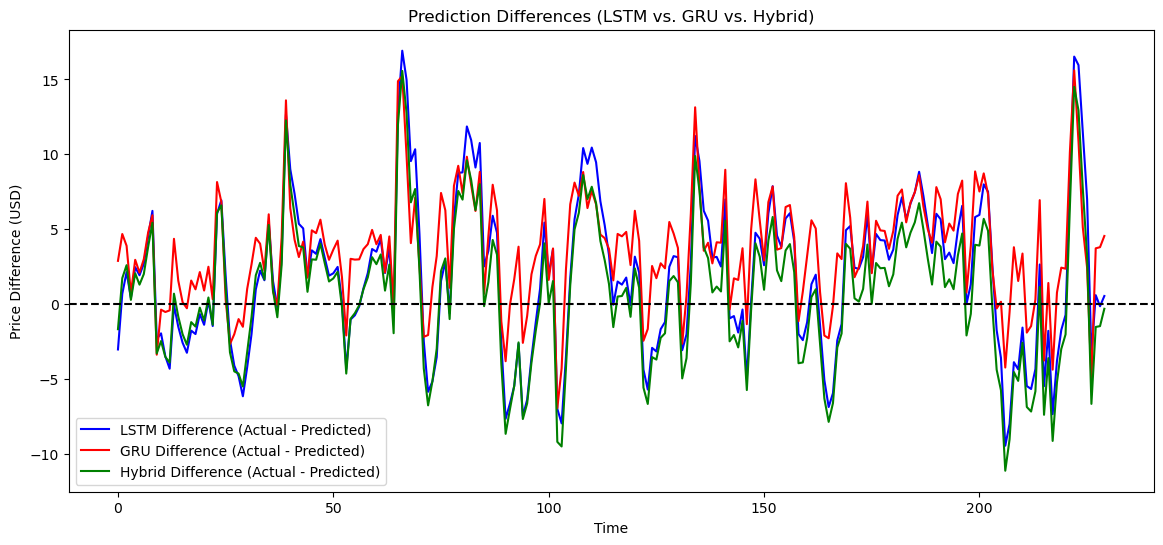

In [75]:
# Calculate prediction differences
lstm_diff = actual_prices - lstm_predicted_prices
gru_diff = actual_prices - gru_predicted_prices
hybrid_diff = actual_prices - hybrid_predicted_prices

plt.figure(figsize=(14,6))
plt.plot(lstm_diff, label="LSTM Difference (Actual - Predicted)", color='blue')
plt.plot(gru_diff, label="GRU Difference (Actual - Predicted)", color='red')
plt.plot(hybrid_diff, label="Hybrid Difference (Actual - Predicted)", color='green')

plt.axhline(y=0, color='black', linestyle='--')  # Reference line at 0
plt.title("Prediction Differences (LSTM vs. GRU vs. Hybrid)")
plt.xlabel("Time")
plt.ylabel("Price Difference (USD)")
plt.legend()
plt.show()


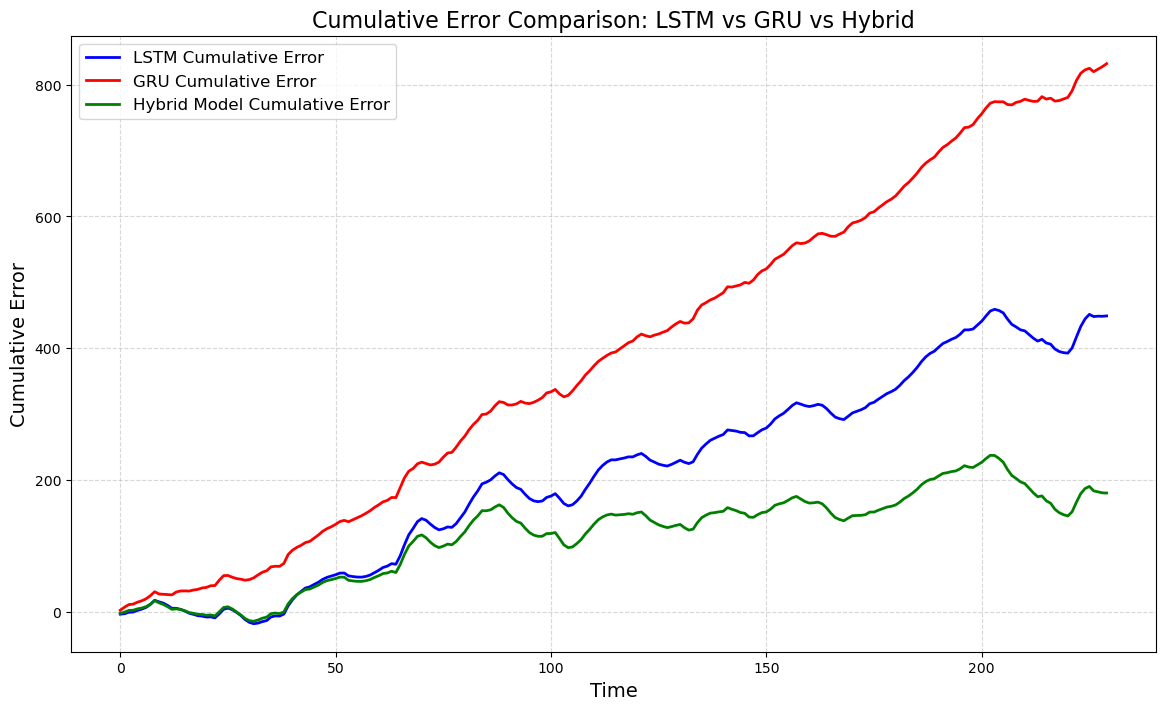

In [77]:
# Calculate cumulative errors for each model
lstm_cumulative_error = (actual_prices - lstm_predicted_prices).cumsum()
gru_cumulative_error = (actual_prices - gru_predicted_prices).cumsum()
hybrid_cumulative_error = (actual_prices - hybrid_predicted_prices).cumsum()

# Plotting cumulative errors
plt.figure(figsize=(14, 8))
plt.plot(lstm_cumulative_error, label="LSTM Cumulative Error", color="blue", linewidth=2)
plt.plot(gru_cumulative_error, label="GRU Cumulative Error", color="red", linewidth=2)
plt.plot(hybrid_cumulative_error, label="Hybrid Model Cumulative Error", color="green", linewidth=2)

# Titles and labels
plt.title("Cumulative Error Comparison: LSTM vs GRU vs Hybrid", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Cumulative Error", fontsize=14)
plt.legend(loc="upper left", fontsize=12)

# Show grid and plot
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# Compute RMSE for LSTM and GRU models
lstm_rmse = np.sqrt(mean_squared_error(actual_prices, lstm_predicted_prices))
gru_rmse = np.sqrt(mean_squared_error(actual_prices, gru_predicted_prices))

# Calculate weights based on inverse RMSE
lstm_weight = 1 / lstm_rmse
gru_weight = 1 / gru_rmse
total_weight = lstm_weight + gru_weight

# Weighted Averaging Hybrid Model
weighted_hybrid_predictions = ((lstm_weight * lstm_predicted_prices) + (gru_weight * gru_predicted_prices)) / total_weight
weighted_hybrid_rmse = np.sqrt(mean_squared_error(actual_prices, weighted_hybrid_predictions))
weighted_hybrid_r2 = r2_score(actual_prices, weighted_hybrid_predictions)

print("Weighted Hybrid Model:")
print(f"Root Mean Squared Error: {weighted_hybrid_rmse}")
print(f"R² Score: {weighted_hybrid_r2}")

Weighted Hybrid Model:
Root Mean Squared Error: 5.054685759763168
R² Score: 0.959934513048566


In [105]:
# Stacking Model Hybrid
X_stack = np.column_stack((lstm_predicted_prices, gru_predicted_prices))
stacking_model = LinearRegression()
stacking_model.fit(X_stack, actual_prices)
stacked_hybrid_predictions = stacking_model.predict(X_stack)
stacked_hybrid_rmse = np.sqrt(mean_squared_error(actual_prices, stacked_hybrid_predictions))
stacked_hybrid_r2 = r2_score(actual_prices, stacked_hybrid_predictions)

print("Stacked Hybrid Model:")
print(f"Root Mean Squared Error: {stacked_hybrid_rmse}")
print(f"R² Score: {stacked_hybrid_r2}")

Stacked Hybrid Model:
Root Mean Squared Error: 3.481311837478313
R² Score: 0.9809949964034388


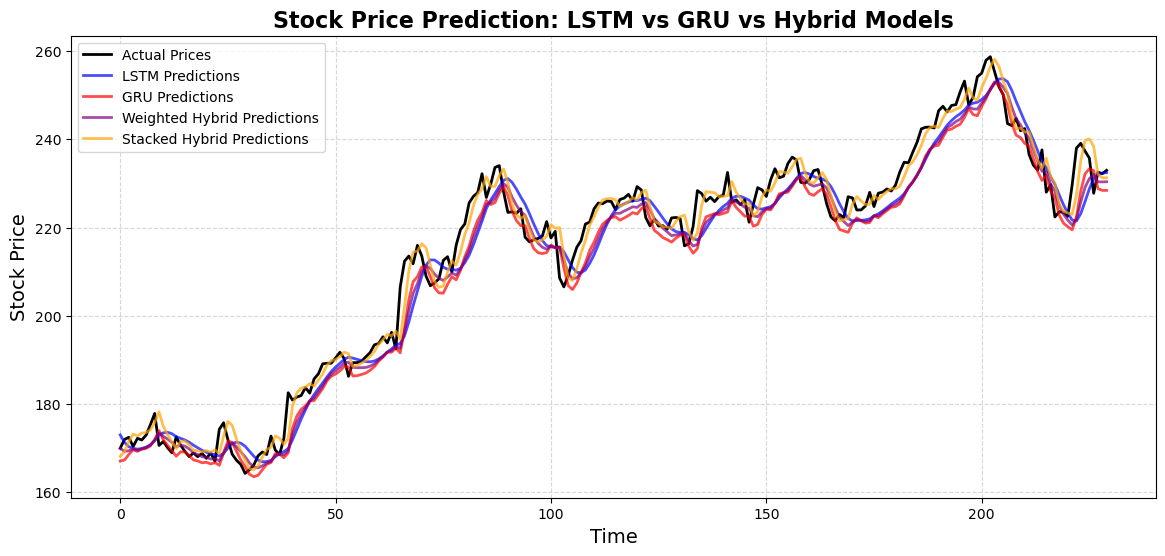

In [107]:
# Plot Comparison
plt.figure(figsize=(14,6))
plt.plot(actual_prices, label="Actual Prices", color='black', linewidth=2)
plt.plot(lstm_predicted_prices, label="LSTM Predictions", color='blue', linewidth=2, alpha=0.7)
plt.plot(gru_predicted_prices, label="GRU Predictions", color='red', linewidth=2, alpha=0.7)
plt.plot(weighted_hybrid_predictions, label="Weighted Hybrid Predictions", color='purple', linewidth=2, alpha=0.7)
plt.plot(stacked_hybrid_predictions, label="Stacked Hybrid Predictions", color='orange', linewidth=2, alpha=0.7)
plt.title("Stock Price Prediction: LSTM vs GRU vs Hybrid Models", fontsize=16, fontweight="bold")
plt.xlabel("Time", fontsize=14)
plt.ylabel("Stock Price", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


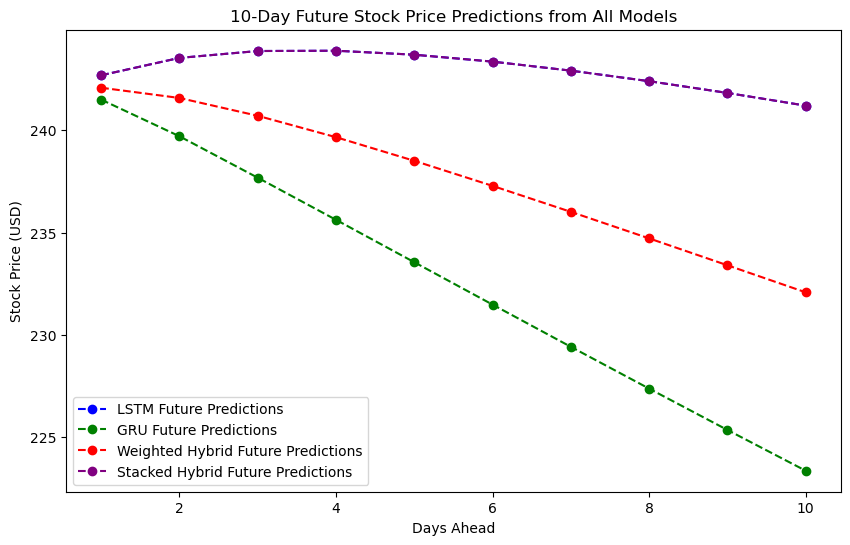

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the last 100 days for future predictions
last_100_days_lstm = scaled_data[-100:].reshape(1, 100, 1)
last_100_days_gru = scaled_data[-100:].reshape(1, 100, 1)

# Initialize empty lists for storing future predictions
future_prediction_lstm = []
future_prediction_gru = []

# Predict the next 10 days using LSTM and GRU models
for _ in range(10):
    lstm_pred = lstm_model.predict(last_100_days_lstm)[0][0]
    gru_pred = gru_model.predict(last_100_days_gru)[0][0]
    future_prediction_lstm.append(lstm_pred)
    future_prediction_gru.append(gru_pred)
    
    # Update inputs for next prediction
    last_100_days_lstm = np.append(last_100_days_lstm[:, 1:, :], [[[lstm_pred]]], axis=1)
    last_100_days_gru = np.append(last_100_days_gru[:, 1:, :], [[[gru_pred]]], axis=1)

# Inverse scale the predictions for LSTM and GRU
future_prices_lstm = scaler.inverse_transform(np.array(future_prediction_lstm).reshape(-1, 1))
future_prices_gru = scaler.inverse_transform(np.array(future_prediction_gru).reshape(-1, 1))

# Calculate RMSE for LSTM and GRU predictions (make sure actual_prices are defined somewhere)
lstm_rmse = np.sqrt(mean_squared_error(actual_prices, lstm_predicted_prices))
gru_rmse = np.sqrt(mean_squared_error(actual_prices, gru_predicted_prices))

# Calculate weights based on inverse RMSE
lstm_weight = 1 / lstm_rmse
gru_weight = 1 / gru_rmse
total_weight = lstm_weight + gru_weight

# Weighted Averaging Hybrid Model predictions
weighted_hybrid_predictions = ((lstm_weight * np.array(future_prediction_lstm)) + (gru_weight * np.array(future_prediction_gru))) / total_weight

# Stacking Model Hybrid (linear regression)
X_stack = np.column_stack((future_prediction_lstm, future_prediction_gru))
stacking_model = LinearRegression()
stacking_model.fit(X_stack, np.array(future_prediction_lstm))  # Assuming LSTM as the target variable
stacked_hybrid_predictions = stacking_model.predict(X_stack)

# Inverse scale the hybrid predictions
weighted_hybrid_predictions = scaler.inverse_transform(weighted_hybrid_predictions.reshape(-1, 1))
stacked_hybrid_predictions = scaler.inverse_transform(stacked_hybrid_predictions.reshape(-1, 1))

# Plot all future predictions in a single plot
plt.figure(figsize=(10, 6))

# Plot future predictions for each model
plt.plot(range(1, 11), future_prices_lstm.flatten(), marker='o', linestyle='dashed', color='blue', label="LSTM Future Predictions")
plt.plot(range(1, 11), future_prices_gru.flatten(), marker='o', linestyle='dashed', color='green', label="GRU Future Predictions")
plt.plot(range(1, 11), weighted_hybrid_predictions.flatten(), marker='o', linestyle='dashed', color='red', label="Weighted Hybrid Future Predictions")
plt.plot(range(1, 11), stacked_hybrid_predictions.flatten(), marker='o', linestyle='dashed', color='purple', label="Stacked Hybrid Future Predictions")

# Title and labels for the plot
plt.title("10-Day Future Stock Price Predictions from All Models")
plt.xlabel("Days Ahead")
plt.ylabel("Stock Price (USD)")
plt.legend()

# Show the plot
plt.show()


In [115]:
# Compare Errors of All Models
print("\nModel Performance Comparison:")
print(f"LSTM RMSE: {lstm_rmse}, R²: {lstm_r2}")
print(f"GRU RMSE: {gru_rmse}, R²: {gru_r2}")
print(f"Hybrid RMSE: {hybrid_rmse}, R²: {hybrid_r2}")
print(f"Weighted Hybrid RMSE: {weighted_hybrid_rmse}, R²: {weighted_hybrid_r2}")
print(f"Stacked Hybrid RMSE: {stacked_hybrid_rmse}, R²: {stacked_hybrid_r2}")


Model Performance Comparison:
LSTM RMSE: 5.393539329366107, R²: 0.9543827173064722
GRU RMSE: 5.154419979038398, R²: 0.9583378849347847
Hybrid RMSE: 0.02317041371962325, R²: 0.9648661913520051
Weighted Hybrid RMSE: 5.054685759763168, R²: 0.959934513048566
Stacked Hybrid RMSE: 3.481311837478313, R²: 0.9809949964034388
